# Gene Expression Analysis Pipeline
This notebook processes gene expression data to identify the top genes that differ most consistently from control means across multiple studies. It then visualizes these differences using PCA.

## My ChatGPT prompt
The code was mostly generated by ChatGPT's Data Analyst model. Below is the prompt that I started with:

> I have multiple studies with gene expression data. Each Study has one or more families/species under study, indicated by the column 'BREED'. Some samples (indicated by the column 'Experiment'), are Controls, and others are treatments, indicated by the Boolean-valued column 'Control'.

> For each sample, use expression counts per million, and filter out genes where CPM < 10 across all samples.

> Exclude the Study named Johnson et al. 2020.

> Within each BREED within each Study, for each gene_id, find the mean and variance of the expression values of the Control samples. So for each BREED, you'll have mean and variance values for the Control samples. Let's call this control_stats_per_breed.
> And then for each non-Control sample within each BREED within each Study, for each gene_id, subtract the gene count from the control_stats_per_breed mean to arrive at difference_from_control_mean for that sample and gene_id.

> I now want to take the top 5000 genes that differ most consistently (with the constraint of statistical significance considering variance) including sign (no absolute values) from their respective control_stats_per_breed means across all Studies. Use a variable for 5000 so that it can be easily changed.

> Report on how you evaluate that statistical significance and give me a sense of the quality of the consistency across Studies for these 5000 genes.

> Perform PCA on these gene-level differences to visualize patterns across studies and families.
> I will provide a gene expression matrix and metadata. Please help me process the data in a memory-efficient way, considering that the dataset may be large.

# Gene Expression Meta-Analysis: Study-Wide Standardization & PCA

## Steps:
1. Load and preprocess data
2. Compute control statistics
3. Compute differences from control means
4. Perform statistical tests and select top genes
5. Perform PCA and visualize results

### **Load Data**
Load the metadata and gene expression matrix.

In [28]:
import pandas as pd
import numpy as np
import os
from scipy.stats import ttest_1samp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load metadata and gene expression data
working_dir = "~/git/Cvirg_Pmarinus_RNAseq/data/"
# === 1️⃣ Load Expression Data (TSV) ===
expression_file = os.path.join(working_dir, "rnaseq_gene_counts", "merged_gene_counts.tsv")
gene_counts = pd.read_csv(expression_file, sep="\t", index_col=0)

# Load the metadata file
metadata_file_path = os.path.join(working_dir, "augmented_metadata.csv")
metadata = pd.read_csv(metadata_file_path)
print (metadata.shape)



(217, 12)


### **Data Preprocessing**
- Start with a **gene expression matrix (CPM - counts per million)**.
- **Filter out genes where CPM < 10 across all samples**.
- **Exclude the study *Johnson et al. 2020***.


In [29]:
# Compute Counts Per Million (CPM)
library_sizes = gene_counts.sum(axis=0)
cpm = (gene_counts / library_sizes) * 1e6

# Filter out genes with CPM < 10 across all samples
filtered_genes = cpm[(cpm >= 10).any(axis=1)]

# Exclude 'Johnson et al. 2020'
excluded_study = 'Johnson et al. 2020'
samples_to_exclude = metadata[metadata['Study'] == excluded_study]['Experiment'].tolist()

filtered_metadata = metadata[~metadata['Experiment'].isin(samples_to_exclude)]
filtered_gene_counts = filtered_genes.drop(columns=samples_to_exclude, errors='ignore')

### **Compute Control Statistics (`control_stats_per_breed`)**
- Within each **Study** and **BREED**, compute:
  - **Mean expression** of control samples per gene.
  - **Variance of expression** of control samples per gene.
- Store these statistics as `control_stats_per_breed`, which will serve as the baseline for comparisons.

[Up to 6 minutes on laptop]


In [30]:
sample_to_breed_study = filtered_metadata.set_index('Experiment')[['Study', 'BREED', 'control']]
control_samples = sample_to_breed_study[sample_to_breed_study['control'] == 1].index

# Compute mean and variance for control samples
control_stats_per_breed = (
    filtered_gene_counts[control_samples]
    .T.join(sample_to_breed_study, how='left')
    .groupby(['Study', 'BREED'])
    .agg(['mean', 'var'])
)
control_stats_per_breed = control_stats_per_breed.swaplevel(axis=1)
control_stats_per_breed.describe()
print(f"Genes with 'var' values: {(control_stats_per_breed.xs('var', level=0, axis=1).count() > 0).sum()}")
print("Shape of control_stats_per_breed:", control_stats_per_breed.shape)



Genes with 'var' values: 26077
Shape of control_stats_per_breed: (9, 52154)


1. **For each Study & Family, Compute Differences from Control Mean:**
   - Identify non-control samples and group them by study and breed (family).
   - Compute the difference between each non-control sample’s gene expression and the control mean for the corresponding study and breed.

2. **In preparation for calculating Standardized Effect Size, compute and adjust standard deviation:**
   - Compute the standard deviation of control samples.
   - Apply a shrinkage technique to stabilize variance estimates due to small control sample sizes.
   - Use a global median standard deviation to avoid division by small variance values.
   - Adjust values below a threshold (experimentally determined as 0.07).

3. **Calculate Standardized Effect Size:**
   - Convert raw differences into __standardized differences__ by dividing them by the adjusted control standard deviation.

4. **Group Samples by Trait (Tolerant vs. Sensitive):**
   - Separate standardized differences into two groups (tolerant vs. sensitive)

Genes with at least one non-null value: 26076
global_std:
Study             BREED                   
Chan et al. 2021  Crassostrea gigas           3.250931
                  Crassostrea virginica       2.327833
P&S 2020          ABC_VIMS_Family_2014_242    4.589701
                  ABC_VIMS_Family_2014_266    4.829261
P&S 2021          ABC_VIMS_Family_2014_286    5.030704
P&S 2023          ABC_VIMS_Family_2017084     3.158108
                  ABC_VIMS_Family_2017089     2.053652
                  ABC_VIMS_Family_2017090     1.720959
                  ABC_VIMS_Family_2017120     2.273810
dtype: float64
Smallest nonzero control standard deviation (after fix): 0.07002816311157826
Sensitive
Max standardized difference: 21491.115041423673
Min standardized difference: -319.7680804669657
Mean absolute standardized difference: 2.3513916335480447


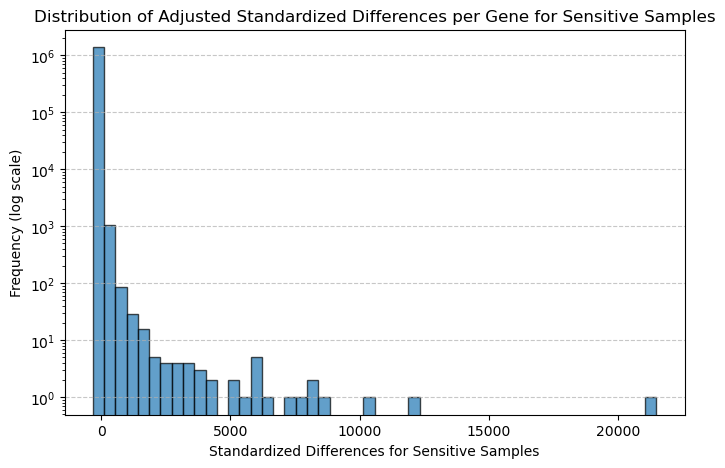

Tolerant
Max standardized difference: 8426.168413258498
Min standardized difference: -223.23647484964226
Mean absolute standardized difference: 1.8390700031783884


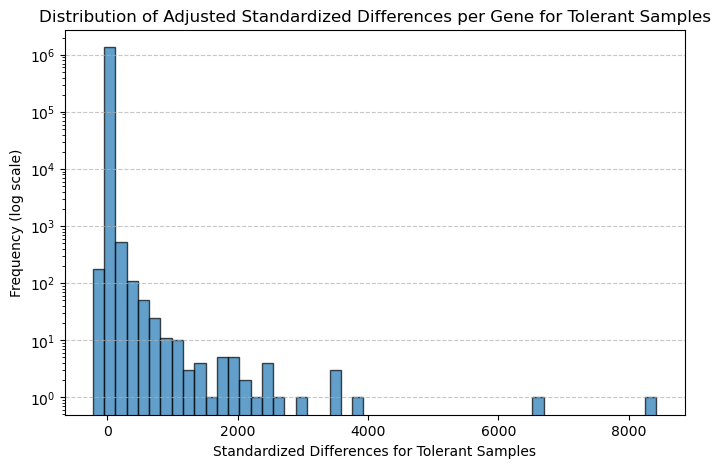

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, combine_pvalues

differences = []
non_control_samples = sample_to_breed_study[sample_to_breed_study['control'] == 0].index

for (study, breed), group in sample_to_breed_study.loc[non_control_samples].groupby(['Study', 'BREED']):
    if (study, breed) in control_stats_per_breed.index:
        control_means = control_stats_per_breed.loc[(study, breed)]['mean']
        samples = group.index
        subset = filtered_gene_counts.loc[:, samples]
        difference_from_control_mean = subset.sub(control_means, axis=0)
        differences.append(difference_from_control_mean)


differences_df = pd.concat(differences, axis=1)
print(f"Genes with at least one non-null value: {(differences_df.count(axis=1) > 0).sum()}")

# Compute control standard deviation
control_variance = control_stats_per_breed.xs("var", level=0, axis=1)
control_std = np.sqrt(control_variance.replace(0, np.nan))
control_std = control_std.T  # Transpose so genes become rows

aligned_control_std = control_std.copy()

# Because we have few control samples per family (min 3), raw variance will be unstable.
# So we use median global standard deviation to avoid dividing by extremely small variance values.
# ChatGPT called this "Bayesian Shrinkage for Variance"
shrink_factor = 0.5  # Adjust to control shrinkage level
global_std = control_std[control_std > 0].median()  
print (f"global_std:\n{global_std}")

# Define a threshold to replace very small values
threshold = 0.07  # Values below this will be adjusted. 0.07 was arrived at by experimentation

# Expand global_std to match aligned_control_std (26077 genes, 9 BREEDs)
shrink_values = pd.DataFrame(np.tile(global_std.values, (aligned_control_std.shape[0], 1)),
                             index=aligned_control_std.index,
                             columns=aligned_control_std.columns) * shrink_factor

# Apply mask
aligned_control_std = aligned_control_std.mask(aligned_control_std < threshold, shrink_values)

# Debugging: Check new min standard deviation
print("Smallest nonzero control standard deviation (after fix): " +
      f"{aligned_control_std[aligned_control_std > 0].min().min()}")

# Compute standardized effect size
differences_df = differences_df.astype(np.float32)  # Ensure memory efficiency

# Map each sample to its BREED
breed_mapping = filtered_metadata.set_index("Experiment")["BREED"]

# Expand aligned_control_std to match sample structure
sample_breeds = filtered_metadata.set_index("Experiment")[["Study", "BREED"]]  # Keep Study and BREED
sample_breeds = sample_breeds.reindex(differences_df.columns)  # Align with sample order

# Convert DataFrame rows into a list of tuples
sample_breeds_tuples = list(map(tuple, sample_breeds.values))
# Create MultiIndex
sample_breeds_index = pd.MultiIndex.from_tuples(sample_breeds_tuples, names=["Study", "BREED"])

differences_df.index.name = "gene_id"
aligned_control_std.index.name = "gene_id"

# Reindex using the full MultiIndex
expanded_control_std = aligned_control_std.reindex(columns=sample_breeds_index, fill_value=np.nan)

# Compute __standarized differences__: differences divided by respective standard deviations
standardized_differences = differences_df.div(expanded_control_std.values)

# Split data into tolerant and sensitive groups
tolerant_samples = filtered_metadata[filtered_metadata["Trait"] == "tolerant"]["Experiment"]
sensitive_samples = filtered_metadata[filtered_metadata["Trait"] == "sensitive"]["Experiment"]
valid_tolerant_samples = tolerant_samples[tolerant_samples.isin(standardized_differences.columns)]
valid_sensitive_samples = sensitive_samples[sensitive_samples.isin(standardized_differences.columns)]

# Separate standardized differences for tolerant and sensitive samples
standardized_differences_tolerant = standardized_differences[valid_tolerant_samples]
standardized_differences_sensitive = standardized_differences[valid_sensitive_samples]

for label, standardized_diffs in (("Sensitive", standardized_differences_sensitive),
                                        ("Tolerant", standardized_differences_tolerant)):# Check whether stabilization of variances worked
    print (label)
    print("Max standardized difference:", standardized_diffs.max().max())
    print("Min standardized difference:", standardized_diffs.min().min())
    print("Mean absolute standardized difference:", standardized_diffs.abs().mean().mean())

    # Plot a histogram of standardized differences to visualize distribution
    plt.figure(figsize=(8, 5))
    plt.hist(standardized_diffs.values.flatten(), bins=50, edgecolor="black", alpha=0.7)
    plt.yscale("log")  # Use log scale to better visualize extreme values
    plt.xlabel(f"Standardized Differences for {label} Samples")
    plt.ylabel("Frequency (log scale)")
    plt.title(f"Distribution of Adjusted Standardized Differences per Gene for {label} Samples")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()



### **Select the Top 5000 Most Consistently Deviant Genes**
Separately for the tolerant and sensitive samples, do the following:
- **Meta-analyze across studies** to determine which genes **deviate most consistently** from their control means
- To evaluate consistency across studies, use `I²` **(I-squared)** **heterogeneity**.
- **Select genes based on:**
  - **P-value (`combined_p_value < threshold`)** → Statistical significance.
  - **I² (`I_squared < threshold`)** → Consistency across studies.
  - **Sort genes by hightes `weighted_mean` (difference from Control) and pick the top 5000**.


In [39]:
# Group data by Study
study_groups = []
for study, study_df in filtered_metadata.groupby("Study"):
    matching_samples = study_df["Experiment"].values  # Get sample IDs
    valid_samples = [s for s in matching_samples if s in standardized_differences.columns]  # Filter only valid samples
    study_data = standardized_differences[valid_samples]  # Select samples as columns
    if not study_data.empty:
        study_groups.append((study, study_data))

print(f"Total study groups: {len(study_groups)}")
for study, df in study_groups[:5]:  # First 5 studies
    print(f"Study: {study} | Shape: {df.shape} | First 5 columns (samples): {df.columns[:5].tolist()}")


Total study groups: 4
Study: Chan et al. 2021 | Shape: (26077, 4) | First 5 columns (samples): ['SRX13037868', 'SRX13037867', 'SRX13037863', 'SRX13037862']
Study: P&S 2020 | Shape: (26077, 30) | First 5 columns (samples): ['SRX7172559', 'SRX7172553', 'SRX7172552', 'SRX7172524', 'SRX7172558']
Study: P&S 2021 | Shape: (26077, 26) | First 5 columns (samples): ['SRX9845543', 'SRX9845542', 'SRX9845541', 'SRX9845540', 'SRX9845511']
Study: P&S 2023 | Shape: (26077, 49) | First 5 columns (samples): ['SRX18040064', 'SRX18040062', 'SRX18040061', 'SRX18040060', 'SRX18040059']


In [111]:
# Compute meta-analysis statistics for each gene

# Function to compute effect size and heterogeneity per gene
import numpy as np
from scipy.stats import ttest_1samp, combine_pvalues

def meta_analysis_per_gene(gene_id, study_groups):
    epsilon = 1e-6  # Small constant to avoid zero variance issues

    effect_sizes = []
    variances = []
    p_values = []

    # Iterate over study_groups, which is a list of tuples (study, df)
    for study, df in study_groups:  
        # df has shape (genes, num_samples_in_study_group) Sample names are column headings
        if gene_id in df.index:
            values = df.loc[gene_id].dropna().values  # Extract non-null values
            if len(values) > 1:  
                t_stat, p_val = ttest_1samp(values, 0, nan_policy="omit")
                mean_effect = np.mean(values)
                var_effect = np.var(values, ddof=1)  

                effect_sizes.append(mean_effect)
                variances.append(var_effect)
                p_values.append(p_val)

    # effect_sizes is array of mean effects, one for each study. If not enough studies, return NaN
    if len(effect_sizes) < 2:
        # print ("effect_sizes < 2")
        return np.nan, np.nan, np.nan, np.nan, []

    # Convert to numpy arrays
    effect_sizes = np.array(effect_sizes)
    variances = np.array(variances)
    p_values = np.array(p_values)

    if np.all(np.isclose(effect_sizes, effect_sizes[0])):
        print ("effect sizes nearly identical")
        return np.nan, np.nan, np.nan, np.nan, []  # Skip unstable genes

    # **Compute mean variance across studies for this gene**

    # **Apply variance clipping**
    clipped_variance_min = 1e-3  # Maximum allowed variance
    variances = np.clip(variances, clipped_variance_min, None)

    variance_mean = np.mean(variances)

    # Compute weights using the clipped variance_mean
    weights = 1 / variance_mean

    # Compute weighted mean effect size
    weighted_mean = np.sum(weights * np.array(effect_sizes)) / np.sum(weights)

    # Compute Cochran's Q-statistic for heterogeneity
    Q_stat = np.sum(weights * (np.array(effect_sizes) - weighted_mean) ** 2)

    # Compute I² heterogeneity measure
    I_squared = max(0, (Q_stat - (len(effect_sizes) - 1)) / (Q_stat + 1e-6)) * 100 if Q_stat > 0 else 0

    # Clip p-values to prevent log(0) issues
    p_values = np.clip(p_values, 1e-15, 1)

    # Combine p-values using Fisher’s method
    combined_p_value = combine_pvalues(p_values)[1] if len(p_values) > 1 else p_values[0]

    return weighted_mean, Q_stat, I_squared, combined_p_value, variances


# Filter study groups to contain only sensitive samples
study_groups_sensitive = [
    (study, df[df.columns.intersection(valid_sensitive_samples)])
    for study, df in study_groups if not df[df.columns.intersection(valid_sensitive_samples)].empty
]
study_groups_tolerant = [
    (study, df[df.columns.intersection(valid_tolerant_samples)])
    for study, df in study_groups if not df[df.columns.intersection(valid_tolerant_samples)].empty
]


# Meta-analysis per gene for tolerant samples
meta_results_tolerant = {
    gene: meta_analysis_per_gene(gene, study_groups_tolerant)
    for gene in standardized_differences_tolerant.index
}
# Meta-analysis per gene for sensitive samples
meta_results_sensitive = {
    gene: meta_analysis_per_gene(gene, study_groups_sensitive)
    for gene in standardized_differences_sensitive.index
}
# Convert to DataFrame
meta_df_tolerant = pd.DataFrame.from_dict(meta_results_tolerant, orient="index",
                                          columns=["weighted_mean", "Q_stat", "I_squared", "combined_p_value", "variances"])
meta_df_sensitive = pd.DataFrame.from_dict(meta_results_sensitive, orient="index",
                                           columns=["weighted_mean", "Q_stat", "I_squared", "combined_p_value", "variances"])

# Debugging: Check meta-analysis DataFrame shape
print(f"Shape of meta_df_tolerant: {meta_df_tolerant.shape} (expected: (n_genes, 5))")
print(f"Shape of meta_df_sensitive: {meta_df_sensitive.shape} (expected: (n_genes, 5))")


/home/syost/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


KeyboardInterrupt: 

Sensitive: Summary statistics for meta_df:
       weighted_mean        Q_stat     I_squared  combined_p_value  \
count   25929.000000  25929.000000  26077.000000      2.592900e+04   
mean        1.528223     11.374881     36.982320      9.370665e-02   
std        16.606155     38.797314     36.453191      1.888255e-01   
min      -143.186096      0.000533      0.000000      4.491731e-55   
25%        -1.672194      1.515792      0.000000      6.276224e-06   
50%         0.104605      4.331380     31.216907      3.353578e-03   
75%         2.405493     11.354436     73.740071      7.862679e-02   
max      1714.747648   3656.043103     99.945296      9.988377e-01   

       variance_mean  variance_max  variance_min   num_studies  
count   2.592900e+04  2.592900e+04  25929.000000  26077.000000  
mean    7.903027e+02  2.734601e+03      0.321319      3.906124  
std     4.612487e+04  1.500099e+05      0.409983      0.419561  
min     1.000000e-03  1.000000e-03      0.001000      0.000000  
2

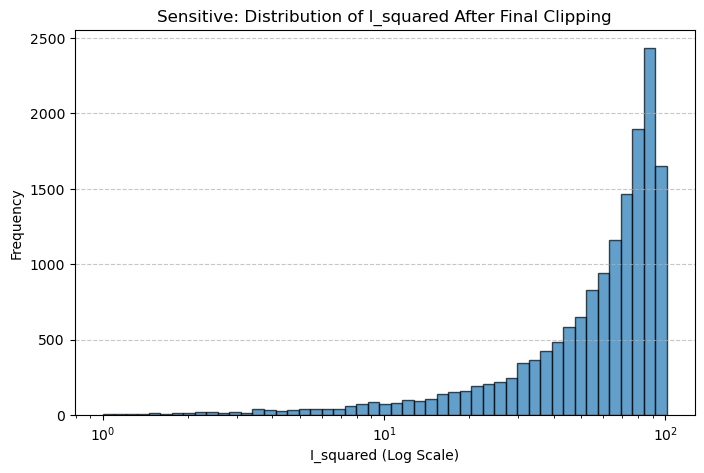

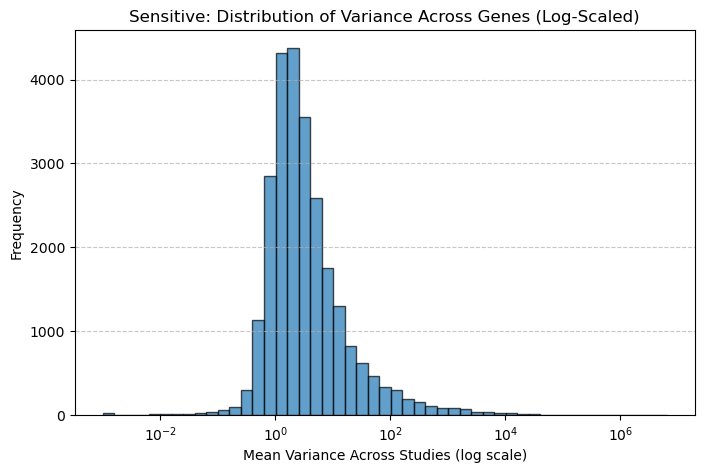

Tolerant: Summary statistics for meta_df:
       weighted_mean        Q_stat     I_squared  combined_p_value  \
count   25874.000000  25874.000000  26077.000000      2.587400e+04   
mean        0.661286      8.738091     30.018615      8.457423e-02   
std         6.895086     36.082728     35.388946      1.824643e-01   
min       -82.004161      0.000012      0.000000      3.743059e-50   
25%        -1.369618      1.011056      0.000000      7.714968e-07   
50%        -0.063233      2.819150      2.252299      1.504925e-03   
75%         1.469686      8.368435     65.673813      6.199260e-02   
max       381.051173   2662.465768     99.924898      9.993517e-01   

       variance_mean  variance_max  variance_min   num_studies  
count   25874.000000  2.587400e+04  25874.000000  26077.000000  
mean      169.331551  5.610331e+02      0.342267      3.687234  
std      6470.249175  2.277544e+04      1.152166      0.586415  
min         0.001000  1.000000e-03      0.001000      0.000000  
25

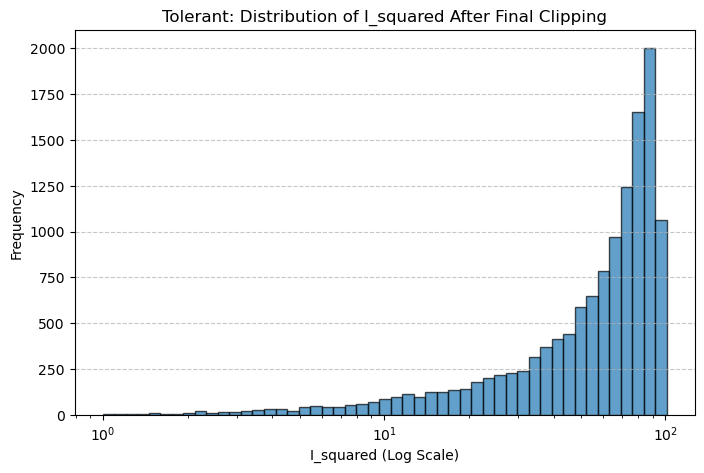

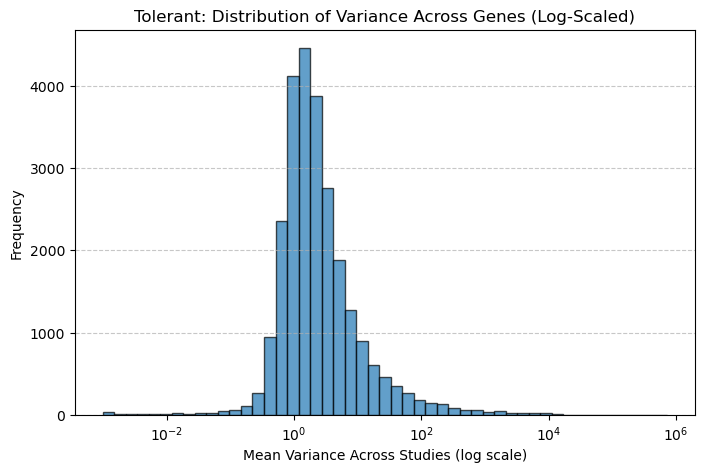

In [ ]:
for label, meta_df in (("Sensitive", meta_df_sensitive), ("Tolerant", meta_df_tolerant)):
    # Expand variances column (which is currently a list per gene)
    meta_df["variance_mean"] = meta_df["variances"].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
    meta_df["variance_max"] = meta_df["variances"].apply(lambda x: np.max(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
    meta_df["variance_min"] = meta_df["variances"].apply(lambda x: np.min(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
    meta_df["num_studies"] = meta_df["variances"].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0)

    print(f"{label}: Summary statistics for meta_df:")
    print(meta_df.describe())
    print(meta_df.head(5))

    # Reclip `Q_stat` to prevent runaway values
    # Further clip Q_stat to prevent excessive values
    # Not needed
    # print("Pre-clip Q_stat summary:\n", meta_df["Q_stat"].describe())
    # meta_df["Q_stat"] = np.clip(meta_df["Q_stat"], 0, 1e4)
    # Debugging: Check new minimum variance
    # print("Clipped Q_stat summary:\n", meta_df["Q_stat"].describe())

    # Recompute I_squared using the updated Q_stat
    # meta_df["I_squared"] = np.where(
    #    meta_df["Q_stat"] > 0,
    #    np.maximum(0, (meta_df["Q_stat"] - (meta_df["num_studies"] - 1)) / (meta_df["Q_stat"] + 1e-6)) * 100,
    #    0
    #)

    # Show updated I_squared summary
    # print("Updated I_squared summary:\n", meta_df["I_squared"].describe())

    # Plot I_squared histogram to confirm improvements
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(8, 5))
    plt.hist(meta_df["I_squared"].dropna(),
            bins=np.logspace(np.log10(meta_df["I_squared"].min() + 1),
                            np.log10(meta_df["I_squared"].max() + 1), 50),
                            edgecolor="black", alpha=0.7)
    plt.xscale("log")  # Log scale for better visualization
    plt.xlabel("I_squared (Log Scale)")
    plt.ylabel("Frequency")
    plt.title(f"{label}: Distribution of I_squared")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    import matplotlib.pyplot as plt
    # Drop zero and near-zero values to avoid log issues
    filtered_variances = meta_df["variance_mean"].replace(0, np.nan).dropna()

    # Plot histogram with log scale
    plt.figure(figsize=(8, 5))
    plt.hist(filtered_variances, bins=np.logspace(np.log10(filtered_variances.min()), np.log10(filtered_variances.max()), 50), edgecolor="black", alpha=0.7)
    plt.xscale("log")  # Use log scale on x-axis
    plt.xlabel("Mean Variance Across Studies (log scale)")
    plt.ylabel("Frequency")
    plt.title(f"{label}: Distribution of Variance Across Genes (Log-Scaled)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

### Filtering
1. Filter by statistical significance and homogeneity, separately within each of (Sensitive, Tolerant) sample sets.
2. Select the top 5000 genes with the largest deviation from control mean.
3. Filter out those whose deviation is too similar between sensitive and tolerant.


In [104]:

# Step 1: Apply significance and homogeneity filters separately
filtered_genes = {}

for label, meta_df in (("Sensitive", meta_df_sensitive), ("Tolerant", meta_df_tolerant)):
    # Apply significance and homogeneity filters
    filtered = meta_df[(meta_df["combined_p_value"] < 0.05) & (meta_df["I_squared"] < 20)]
    
    # Store filtered genes
    filtered_genes[label] = filtered

# Step 2: Select the top 5000 genes **across both groups**
# Combine filtered results
combined_filtered = pd.concat(filtered_genes.values())

# Compute absolute deviation from control mean
combined_filtered["abs_deviation"] = combined_filtered["weighted_mean"].abs()
combined_filtered = combined_filtered[~combined_filtered.index.duplicated(keep="first")]

# Select the top 5000 genes with the largest deviation (across both groups)
top_genes = combined_filtered.nlargest(min(5000, len(combined_filtered)), "abs_deviation")

# Ensure exactly 5000 unique gene names
top_gene_list = top_genes.index.unique()[:5000]

# Step 3: Filter out those whose deviation is too similar between sensitive and tolerant.

# Extract sensitive and tolerant data for top selected genes (ensuring correct order)
meta_sensitive_selected = filtered_genes["Sensitive"].loc[
    filtered_genes["Sensitive"].index.intersection(top_gene_list)
]
meta_tolerant_selected = filtered_genes["Tolerant"].loc[
    filtered_genes["Tolerant"].index.intersection(top_gene_list)
]

# Create a dataframe to compare deviations (keeping all selected genes)
deviation_df = pd.DataFrame(index=top_gene_list)
deviation_df["Sensitive"] = meta_sensitive_selected["weighted_mean"]
deviation_df["Tolerant"] = meta_tolerant_selected["weighted_mean"]

# Fill missing values with NaN (since genes may not be in both groups)
deviation_df = deviation_df.reindex(top_gene_list)

# Compute deviation difference (raw, not absolute)
deviation_df["diff"] = (deviation_df["Sensitive"] - deviation_df["Tolerant"]).abs()

# Define a similarity threshold (e.g., 99.999% of the mean deviation across all genes)
threshold = 0.99999 * deviation_df[["Sensitive", "Tolerant"]].mean().mean()

# Retain genes where deviation difference is above the threshold or
# they're only in one of (Sensitive, Tolerant)
final_genes = deviation_df.loc[
    (deviation_df["diff"] > threshold) | 
    (deviation_df["Sensitive"].notna() & deviation_df["Tolerant"].isna()) | 
    (deviation_df["Tolerant"].notna() & deviation_df["Sensitive"].isna())
]

print(f"Total genes selected after filtering: {len(final_genes)}")
print(final_genes.describe())

# Retrieve full metadata for selected genes
final_meta_sensitive = meta_sensitive_selected.loc[final_genes.index.intersection(meta_sensitive_selected.index)]
final_meta_tolerant = meta_tolerant_selected.loc[final_genes.index.intersection(meta_tolerant_selected.index)]

print(f"Final sensitive genes: {len(final_meta_sensitive)}")
print(f"Final tolerant genes: {len(final_meta_tolerant)}")
print(f"Genes common to both: {len(set(final_meta_sensitive.index) & set(final_meta_tolerant.index))}")
print(f"Genes only in sensitive: {len(set(final_meta_sensitive.index) - set(final_meta_tolerant.index))}")
print(f"Genes only in tolerant: {len(set(final_meta_tolerant.index) - set(final_meta_sensitive.index))}")

# Show results
print(f"Total genes selected after filtering: {len(final_genes)}")


Total genes selected after filtering: 4147
         Sensitive     Tolerant        diff
count  1687.000000  2759.000000  299.000000
mean      7.475859     5.829575   27.811719
std      47.669879    16.546868   46.845023
min     -27.420984    -9.716058    5.162465
25%      -1.117573     1.075775    7.428169
50%       1.667976     1.874674   12.105439
75%       4.997807     4.707803   23.136610
max    1714.747648   381.051173  339.900464
Final sensitive genes: 1687
Final tolerant genes: 2759
Genes common to both: 299
Genes only in sensitive: 1388
Genes only in tolerant: 2460
Total genes selected after filtering: 4147


### **Perform PCA on Standardized Differences**
- **Principal Component Analysis (PCA)** on **selected genes**.
- **Color points by Study**.
- **Differentiate sample types (`trait`) using symbols (`X` for sensitive, `dot` for tolerant`).**
- **Ensure percentage variance is shown on axis labels**.



Genes before filtering: 26077
Genes after filtering: 4147
86394
NaN per gene:gene_id
LOC111099049    16
LOC111099052    27
LOC111099069     2
LOC111099098     2
LOC111099119     2
                ..
LOC111138329     2
LOC111138336    40
LOC111138387     4
LOC111138426     2
LOC111138496     2
Length: 1522, dtype: int64
Number of genes without NaNs: 2625


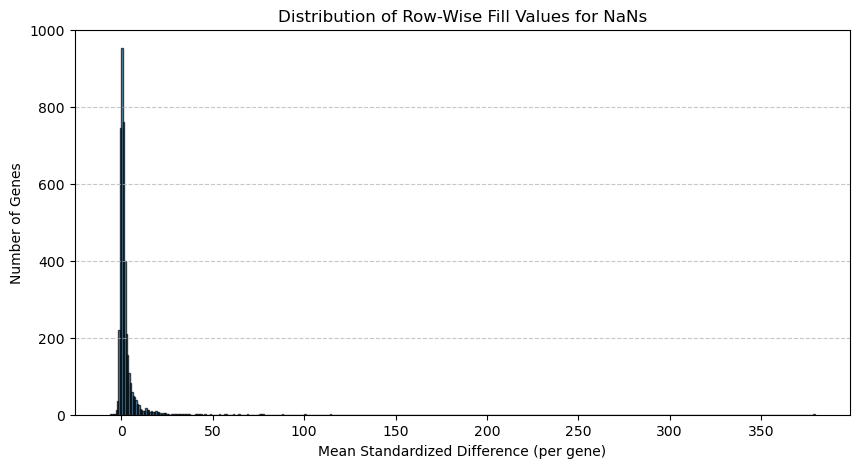

NaN handling complete: No missing values remain. Proceeding with PCA.


In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Identify the filtered gene set
filtered_genes = final_meta_sensitive.index.union(final_meta_tolerant.index)  # Union of selected genes

# Step 2: Filter the standardized_differences dataframe to include only our significant genes 
# Ensure filtered_genes is a set for efficient lookup
filtered_genes_set = set(filtered_genes)

# Filter standardized_differences to keep only genes in filtered_genes
standardized_differences_filtered = standardized_differences.loc[
    standardized_differences.index.intersection(filtered_genes_set)
]

# Display the number of genes remaining after filtering
print(f"Genes before filtering: {standardized_differences.shape[0]}")
print(f"Genes after filtering: {standardized_differences_filtered.shape[0]}")

# Step 3: Standardize Data (PCA requires normalization)
scaler = StandardScaler()
pca_scaled = scaler.fit_transform(standardized_differences_filtered)
print(standardized_diffs.isnull().sum().sum())
nan_per_sample = standardized_differences_filtered.isnull().sum()
nan_per_sample[nan_per_sample > 0]  # Show only samples with NaNs
nan_per_gene = standardized_differences_filtered.isnull().sum(axis=1)
print(f"NaN per gene:{nan_per_gene[nan_per_gene > 0]}")  # Show only genes with NaNs
nan_per_gene = standardized_differences_filtered.isnull().sum(axis=1)
genes_with_nans = (nan_per_gene == 0).sum()
print(f"Number of genes without NaNs: {genes_with_nans}")
# Compute the mean per gene (row-wise)
row_means = standardized_differences_filtered.mean(axis=1)

# Plot the distribution of fill values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(row_means, bins=500, edgecolor="black", alpha=0.7)
plt.xlabel("Mean Standardized Difference (per gene)")
plt.ylabel("Number of Genes")
plt.title("Distribution of Row-Wise Fill Values for NaNs")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Drop genes (rows) that contain only NaNs
standardized_differences_cleaned = standardized_differences.dropna(how="all")

# Ensure all remaining NaNs are filled with row-wise mean
standardized_differences_filled = standardized_differences_cleaned.apply(lambda x: x.fillna(x.mean()), axis=1)

# Verify no NaNs remain
num_nans_after = standardized_differences_filled.isnull().sum().sum()

if num_nans_after == 0:
    message = "NaN handling complete: No missing values remain. Proceeding with PCA."
else:
    message = f"Warning: {num_nans_after} NaN values still exist after filling."
print(message)

# Transpose for PCA (samples as rows, genes as columns)
data_for_pca = standardized_differences_filled.T

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca_scaled = scaler.fit_transform(data_for_pca)





In [ ]:

# Step 4: Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_scaled)

# Extract explained variance for axis labeling
explained_variance = pca.explained_variance_ratio_ * 100

filtered_metadata = filtered_metadata.set_index("Experiment")



KeyError: "None of ['Experiment'] are in the columns"

In [ ]:

# Step 5: Create Metadata for Plotting
# Assuming you have metadata that maps samples to Study and Trait
metadata = filtered_metadata.loc[standardized_differences_filled.columns]  # Ensure metadata matches selected samples

# Convert PCA result into DataFrame
pca_df = pd.DataFrame({
    "PC1": pca_result[:, 0],
    "PC2": pca_result[:, 1],
    "Study": metadata["Study"].values,
    "Trait": metadata["Trait"].values  # Sensitive or Tolerant
})

# Step 6: Plot PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1", y="PC2", hue="Study", style="Trait",
    markers={"sensitive": "X", "tolerant": "o"},
    data=pca_df, s=100, edgecolor="black", alpha=0.8
)

# Labels and Title
plt.xlabel(f"PC1 ({explained_variance[0]:.2f}% variance)")
plt.ylabel(f"PC2 ({explained_variance[1]:.2f}% variance)")
plt.title("PCA of Weighted Mean Values (Samples as Dots)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

# Show plot
plt.show()




ValueError: These `markers` levels are missing values: {'sensitive', 'tolerant'}

<Figure size 1000x700 with 0 Axes>

In [94]:
print(pca.explained_variance_ratio_[:10] * 100)
print(np.sum(pca.explained_variance_ratio_[:10]) * 100)


[1.27309461 1.24367672 1.23890046 1.21539951 1.20302227 1.19354361
 1.18921253 1.17351691 1.16999425 1.15337509]
12.053735948974401


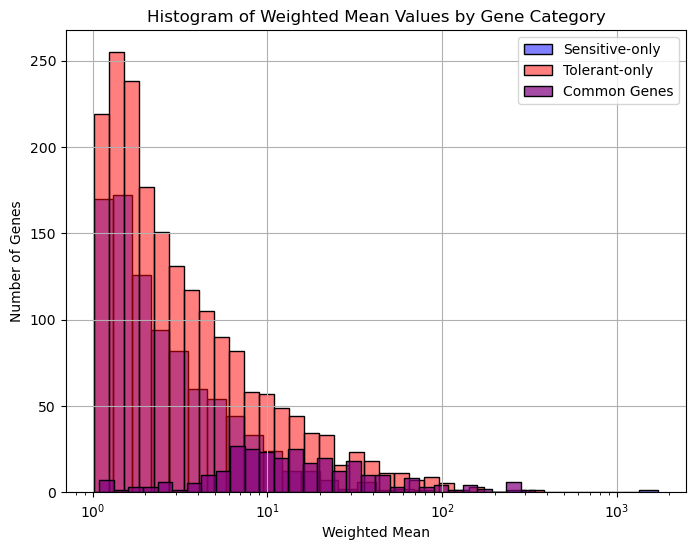

In [97]:
import seaborn as sns

# Extract weighted_mean values
sensitive_values = final_meta_sensitive["weighted_mean"]
tolerant_values = final_meta_tolerant["weighted_mean"]

# Identify common genes
common_genes_index = final_meta_sensitive.index.intersection(final_meta_tolerant.index)

# Identify unique genes
sensitive_only_index = final_meta_sensitive.index.difference(final_meta_tolerant.index)
tolerant_only_index = final_meta_tolerant.index.difference(final_meta_sensitive.index)

# Extract corresponding weighted_mean values
common_genes = final_meta_sensitive.loc[common_genes_index, "weighted_mean"]
sensitive_genes = final_meta_sensitive.loc[sensitive_only_index, "weighted_mean"]
tolerant_genes = final_meta_tolerant.loc[tolerant_only_index, "weighted_mean"]

# Create a histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(sensitive_genes, color="blue", alpha=0.5, label="Sensitive-only", bins=30, log_scale=(True, False))
sns.histplot(tolerant_genes, color="red", alpha=0.5, label="Tolerant-only", bins=30, log_scale=(True, False))
sns.histplot(common_genes, color="purple", alpha=0.7, label="Common Genes", bins=30, log_scale=(True, False))

# Labels and title
plt.xlabel("Weighted Mean")
plt.ylabel("Number of Genes")
plt.title("Histogram of Weighted Mean Values by Gene Category")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()